# Классификация изображений с эмоциями людей

In [107]:
# import os
# dir_to_delete = '/kaggle/working/'
# with os.scandir(dir_to_delete) as entries:
#     for entry in entries:
#         file_to_delete = f"{dir_to_delete}{entry.name}"
#         if os.path.isfile(file_to_delete):
#             print(file_to_delete)
#             os.remove(file_to_delete)

In [108]:
# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.8.3
GPU Device Not Found. Running on CPU


# <b>1. ПОДГОТОВИТЕЛЬНЫЙ ЭТАП</b>

## 1.1. Подготовка файлов для работы с локального диска

### Загрузка данных на локальный диск

In [110]:
# !pip install gdown

In [111]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
ident = '1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output = fname + '.zip')

Downloading...
From: https://drive.google.com/uc?id=1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
To: C:\Users\commi\YandexDisk\code_learning\DS_Sber\Профильный_модуль\SBER_Diploma\emotions.zip
100%|█████████████████████████████████████████████████████████████████████████████| 14.8M/14.8M [00:02<00:00, 4.96MB/s]


Распаковка в текущую директорию.

In [112]:
# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Теперь загруженный архив можно удалить.

In [113]:
import os

os.remove(fname + '.zip')

Переименуем папку с изображениями в `emotions`. Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [114]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [115]:
zip_content = os.listdir(p)[0]
zip_content

'emotions_dataset'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [116]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

### Настройка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [117]:
from pathlib import Path

# Базовая директория
base_dir = p / fname
# # base_dir = '/content/drive/MyDrive/Sber DS/Diploma/data/emotions/'  # for colab
classes = sorted(os.listdir(base_dir))

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [118]:
# class_names = [x.lower() for x in classes]
class_names = sorted(['anger', 'disgust', 'fear', 'joyfulness', 'neutral'])

done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(sorted(class_names)):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = sorted(os.listdir(base_dir))

In [119]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

### Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [120]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [121]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] data\emotions\disgust\5a971597aae6052a008b45a7.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\gettyimages-520925691.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\Universal_Expression_Disgust.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [122]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


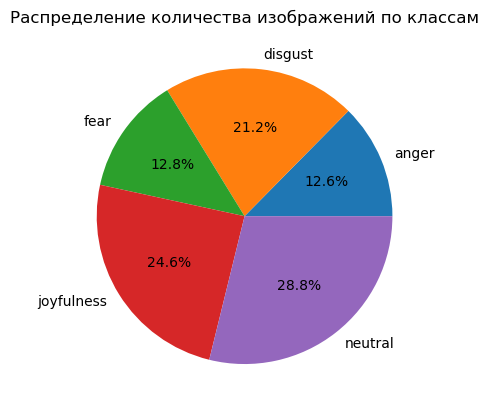

In [123]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать метрики, основанные на `precision` и `recall`, а также матрицу ошибок. 

Посмотрим на названия отдельных файлов.

In [124]:
len(class_names)

5

In [125]:
for i, j in zip(class_names, files_names):
    print(i, j[90:93])

anger ['278101.jpg', '280.jpg', '28185.jpg']
disgust ['199642.jpg', '200122272-003.jpg', '203679.jpg']
fear ['221981.jpg', '225180.jpg', '227900.jpg']
joyfulness ['16932.jpg', '16936.jpg', '171.jpg']
neutral ['1544.jpg', '15494.jpg', '156106.jpg']


### Визуализация оригинальных изображений

Посмотрим на фотографии из обеих субдиректорий - по 4 фотографии каждого класса.

In [126]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Параметры для отрисовки - количество строк и столбцов
nrows = 5
ncols = 4

# Индекс для итерации изображений
pic_index = 0

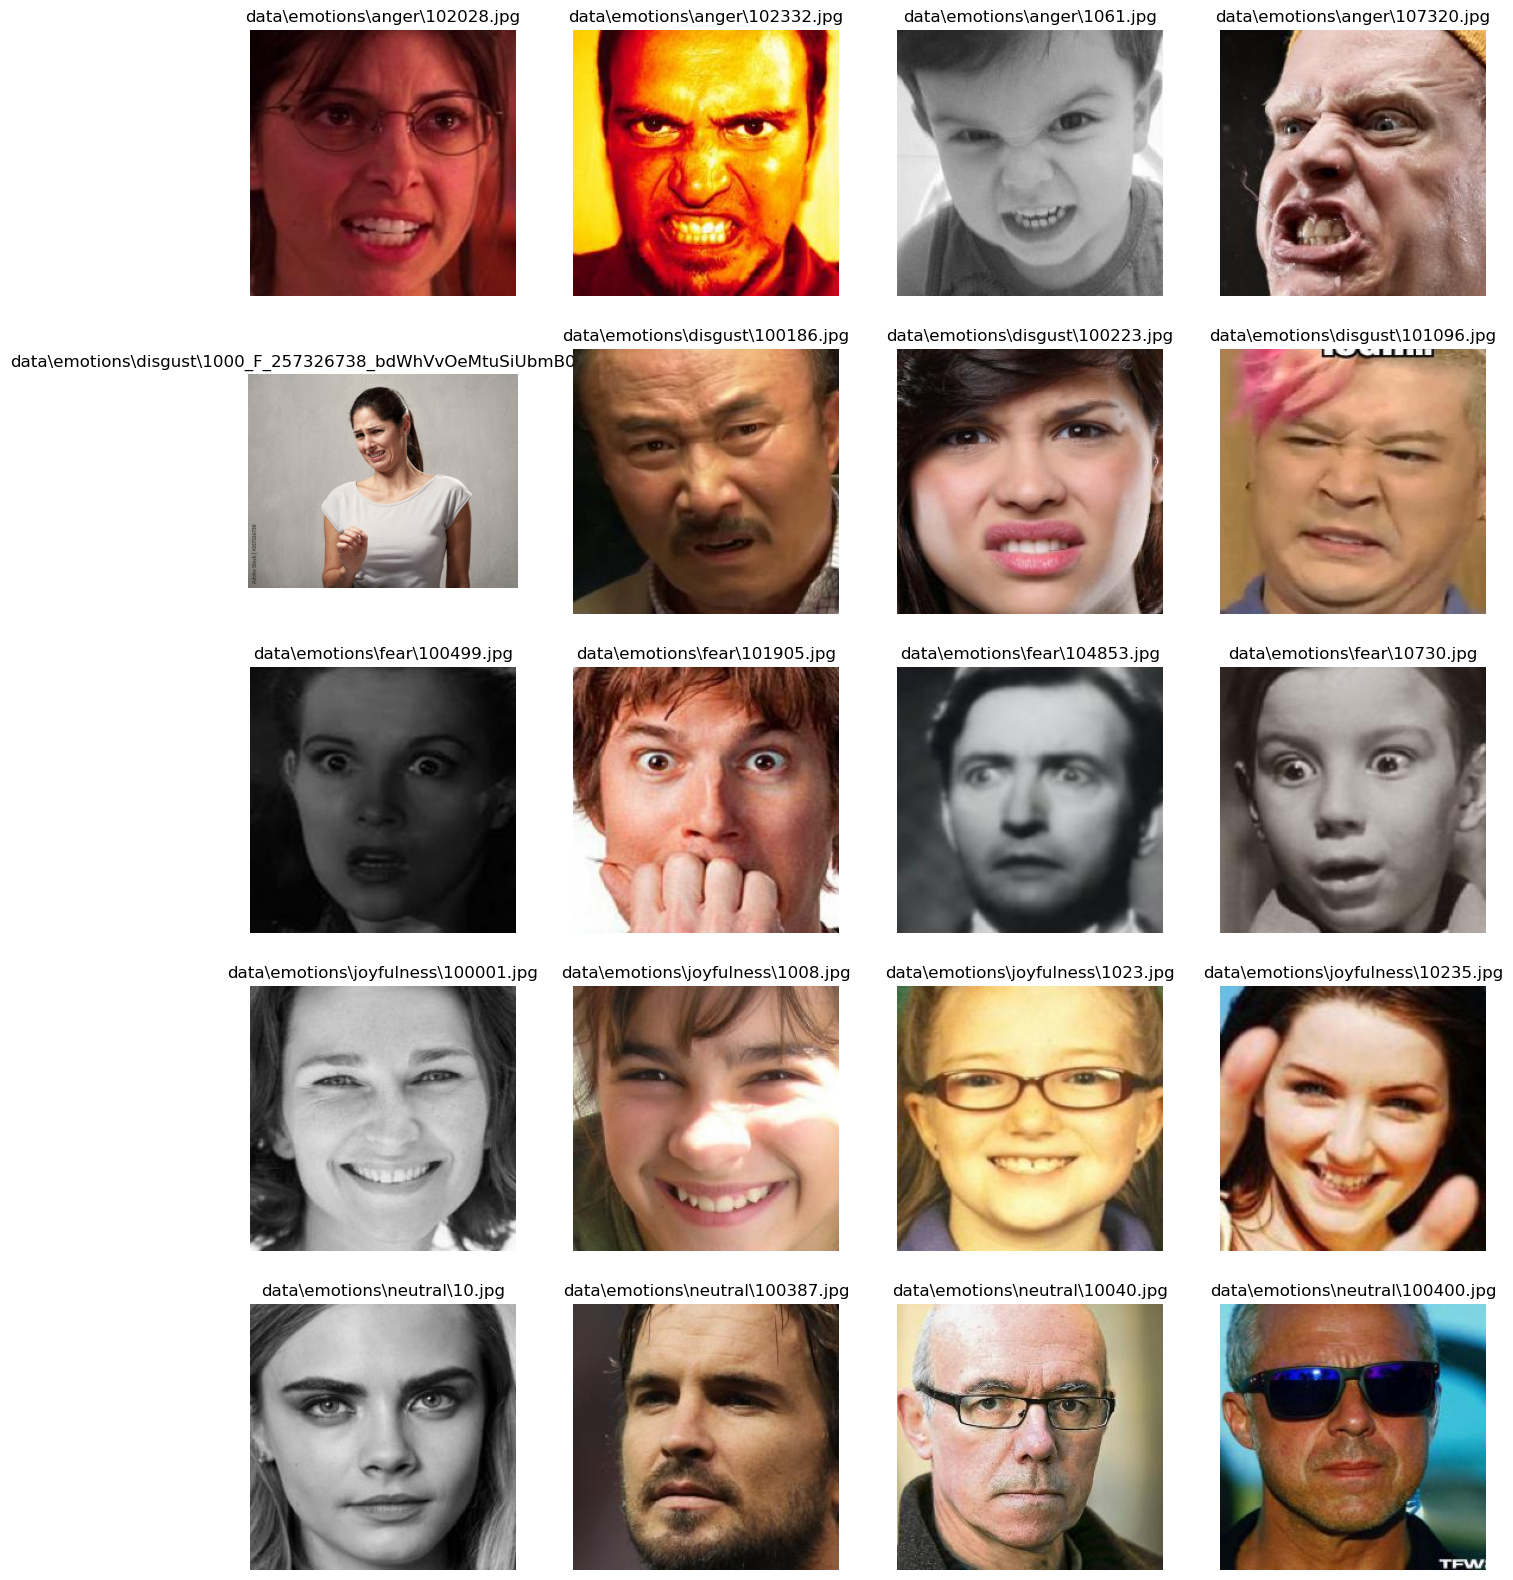

In [127]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и соотношение сторон, их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

### Split изображений

Так как готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) в tensorflow нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1` (значение по умолчанию). Однако при необходимости это соотношение можно изменить в любую сторону, для этого нужно указать значения для тренировочной и валидационной частей, тестовая часть посчитается автоматически как остаток (при этом нужно помнить, что сумма частей, на которые мы делим датасает, должна быть кратна 10; при желании это правило можно изменить, переписав вложенную функцию).

In [128]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1)):
    
    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num//10*relation[0]), int(imgs_num//10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num
        
    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [129]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=sorted(classes)[i],
             # изменим немного соотношение в пользу валидации
             relation=(8, 1.2))

Наш датасет разделен на три части в соотношении 8:1:1. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [130]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

test ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
train ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
validation ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


# 1.2. Подготовка функций и переменных для обучения

## Архитектура, компиляция, обучение модели

`DROPOUT_RATE` назначим небольшим, так как датасет у нас скромный по объему, и, если мы будем исключать значительную часть датасета из обучения, модель просто не сможет обучаться.

Также назначим переменную базовый learning rate - `BASE_LR`, установим значение на 0.01. Мы будем использовать специальный инструмент `callbacks`, который при необходимости будет уменьшать данный параметр непосредственно в ходе обучения.

In [131]:
DROPOUT_RATE = 0.2
BASE_LR = 0.01
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)
EPOCHS=500  # см. callbacks

Также пропишем дополнительную метрику для наших  несбалансированных мультиклассов - PR-AUC с использованием precision и recall. PR-AUC - это площадь под графиком этих двух метрик, позволяет учесть данные по редким классам и получить более объективную картину об эффективности обучения.

In [132]:
curve = 'PR'
name = curve+'_AUC'
AUC = tf.keras.metrics.AUC(curve=curve, multi_label=False, name=name)

metrics = ['accuracy', AUC]

### Callbacks - контроль остановки обучения и `learning_rate`

Так как обучение моделей по компьютерному зрению очень затратно по ресурсам, а мы планируем провести целый ряд различных экспериментов, для снижения нагрузки на систему мы будем использовать так называемые `callbacks` - специальные модули `keras`, которые позволяют в автомтическом режиме контролировать, когда следует вносить те или иные изменения в обучение. Мы будем использовать два вида `callbacks`:

- `EarlyStopping` для ранней остановки обучения при прекращении сокращения `val_loss` (для нашего несбалансированного датасета этот показатель важнее, чем непоказательный для несбалансированных классов `val_accuracy`),

- `ReduceLROnPlateau` для уменьшения `learning rate` при ухудшении показателей `val_loss` (Исследователями обнаружено, что постепенное снижение `learning rate` в процессе обучения положительно сказывается на качестве обучения, что мы увидим на наших экспериментах, см. список использованных источников и литературы Holbrook R. "Intro to Deep Learning").

In [133]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # минимальное значение для зачета улучшения
    patience=10,  # количество эпох с плохим результатом перед остановкой
    restore_best_weights=True,  # восстановить лучшие показатели модели
)

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=0.85,  # на какое значение будет умножаться текущий lr
    min_lr=1e-8,  # минимальное значение lr
)

Таким образом, наши callbacks создают следующий алгоритм: 
- при ухудшении `val_loss` на данной эпохе следующая эпоха будет прходить с `learning rate` в два раза ниже,
- если `val_loss` ухудшается 10 раз кряду, обучение прекращается.

Все эти параметры можно регулировать и подбирать, для наших задач мы остановимся на этих гиперпараметрах, так как они нас устраивают.

## Визуализация итогов обучения

### Функция потерь и метрики

In [134]:
def val_acc_viz(history, epochs, loss_from=1):
    '''
    Функция отрисовывает историю функции потерь и
    используемых метрик. Аргументы:
    - history - данные истории обучения,
    - epochs - количество эпох для отображения,
    - loss_from - с какой эпохи отображать loss.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    auc = history.history[name]
    val_auc = history.history['val_' + name]

    loss = history.history['loss'][loss_from-1:]
    val_loss = history.history['val_loss'][loss_from-1:]

    epochs_range = range(1, len(acc)+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(loss_from, len(acc)+1), loss, label='Training Loss')
    plt.plot(range(loss_from, len(acc)+1), val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    # plt.show()

    # plt.figure(figsize=(8, 5))
    # ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    # plt.subplot(1, 2, 2, sharey=ax1)
    plt.subplot(1, 3, 3, sharey=ax2)
    plt.plot(epochs_range, auc, label='Training ' + name)
    plt.plot(epochs_range, val_auc, label='Validation ' + name)
    plt.legend(loc='best')
    plt.title(name)
    plt.xlabel('epochs')
    plt.show()

### Функция матрицы ошибок

In [166]:
def confusion_matrix(model, dataset, images_number=None, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - images_number - количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке.
    - dataset - tf.dataset с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)

    y_test = list()
    y_pred = list()
    for x, y in test_batches:
        y_test.append(np.argmax(y))
        y_pred.append(np.argmax(model.predict(x)))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='GnBu')
    # disp.plot(cmap='afmhot')

    plt.show()

## Предсказания отдельных изображений

### На изображениях из Сети

При желании качество работы модели можно проверить на реальных фотографиях экспертным методом. Для этого создадим новую папку, куда загрузим желаемые изображения. Далее, подготовленная функция преобразует изображения в необходимый для визуализации и предсказания формат. Оставим эту часть в качестве дополнения, использовать ее пока не будем.

In [ ]:
# from PIL import Image
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# new_test_dir = Path('./data/test_images')
# Path.mkdir(new_test_dir)

# def show_predictions(model):
    
#     images = os.listdir(new_test_dir)
    
#     for i, img_path in enumerate(images):

#         # путь к тестовым изображениям
#         path = new_test_dir / img_path

#         # приведение изображений к желаемому разрешению
#         img = load_img(path, target_size=IMAGE_SIZE + (3,))
#         # перевод изображения в массив
#         x = img_to_array(img)

#         # добавление четвертого измерения для модели
#         images = np.expand_dims(x, axis=0)
        
#         plt.figure(figsize=(2, 2))
#         # Отключить оси
#         plt.axis(False)
#         plt.imshow(np.squeeze(images).astype('uint8'))
#         # plt.title(img_path)
#         plt.show()

#         # предсказание
#         classes = model.predict(images, batch_size=10)

#         class_pred = np.argmax(classes)
#         # print(np.argmax(class_pred))
#         print(f'{img_path} is {class_names[class_pred]} ({np.max(classes[0])*100:.2f}%)')
        
# show_predictions(model)

### На изображениях из тестовой выборки

Посмотрим на то, как модель предсказывает тестовые изображения, хранящиеся в третьей, тестовой выборке, которая до этого момента не принимала участия в работе. Напомним, что тестовая выбора разбита на батчи по одному изображению, что позволяет нам проще контролировать количество изображений, которое мы хотим использовать для предсказания. Следующая функция покажет изображение, заданное и предсказанное значение класса, а также "уверенность" модели в своем предсказании. На данном этапе посмотрим на небольшое количество изображений (по умолчанию 10, можно изменить это число, задав соответствующий аргумент), а полную картину оценим дальше, построив матрицу ошибок.

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, dataset,
                     images_number=10, visualization=False):

    images = dataset.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

# <b>МОДЕЛЬ 1</b> | InceptionResNetV2

В библиотеке TensorFlow существует как минимум два способа использования предобученных моделей:
- использованием библиотеки моделей `tensorflow-hub`,
- с использованием модуля Keras `tf.keras.applications`.

Первый способ проще в имплементации и очень хорошо годится для производства, однако у него есть существенный недостаток для разработчика - предобученные модели поставляются как единый слой и не подлежат частичной разморозке, разморозить можно только все слои зараз, отчего важным становится правильный выбор версии данной модели (то есть мы имеем дело с "семейством" моделей). 

Также при выборе конкретной модели необходимо учесть два момента:
- знать, какой метод `rescale` использовать - [0, 1] или [-1, 1], это необходимо иметь ввиду при подготовке наших изображений перед отправкой на обучение,
- при наличии в предобученной модели батчнорм слоев и разморозке модели отключить обучение батчнорм слоев, иначе работа модели будет происходить непредсказуемым способом. 

Воспользуемся вторым способом, использование модуля Keras, так как он гораздо более пластичен для тонкой настройки и позволяет экспениментировать с гиперпараметрами. 

### InceptionResNetV2

О модели.

### Гиперпараметры для модели с переносом обучения

В самом начале обозначим гиперпараметры для будущей модели, это позволит нам уже сейчас начать подготавливать необходимые команды с этими данными для дальнейшего использования. 

In [33]:
MODULE_HANDLE = 'tf.keras.applications.InceptionResNetV2'
pixels = 299
IMAGE_SIZE = (pixels, pixels)
IMG_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32

print(f"Используем {MODULE_HANDLE}, входное разрешение: {IMAGE_SIZE}, размер батча: {BATCH_SIZE}.")

Используем tf.keras.applications.InceptionResNetV2, входное разрешение: (299, 299), размер батча: 32.


## Создание датасетов под данную предобученную модель

### Создание датасетов | `image_dataset_from_directory`

Для обучения модели и затем конвертации ее в облегченную версию все предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`. В качестве `label_mode` установим `categorical` для перевода лейблов в вид `one_hot_encoding`.

Для корректной работы кода, создающего облегченную версию нашей модели, который мы позаимствовали из курса по компьютерному зрению, тренировочный и валидационный датасеты должны иметь достаточно большой батч, тогда как тестовый датасет должен выдавать по одному изображению зараз, то есть батч должен равняться 1. 

Весь необходимый код оформим в функцию, которая и проделает все операции.

In [34]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  seed=123,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical'):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [35]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [36]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 299, 299, 3)
(32, 299, 299, 3)
(1, 299, 299, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат в батче установленное количество изображений, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [37]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)

class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


### Визуализация изображений из `train_batches`

C:\Users\commi\AppData\Local\Temp\ipykernel_9516\3032689920.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(4, 4, i+1)


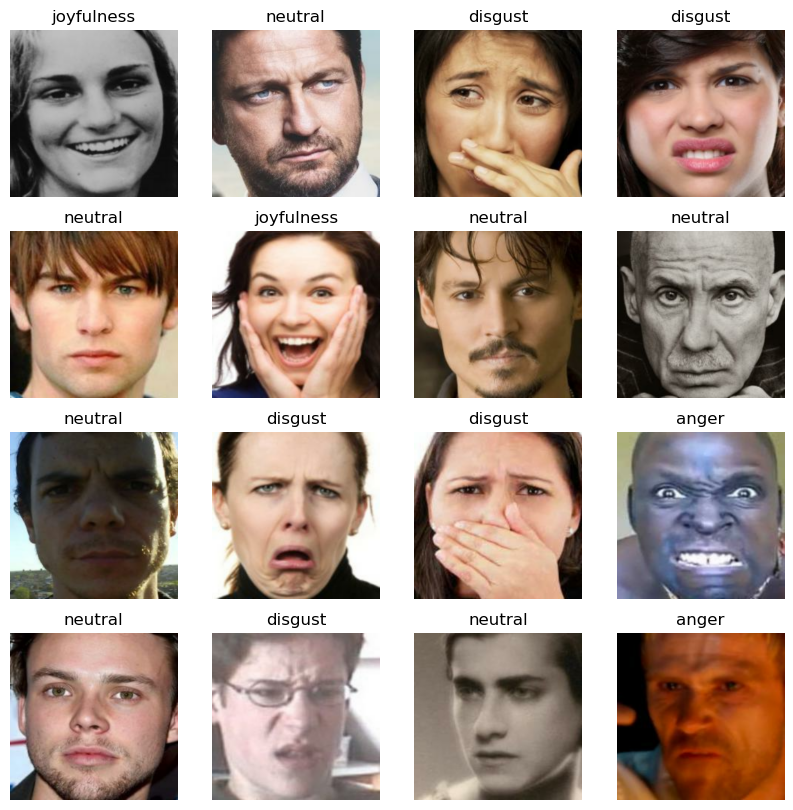

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(10):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(299, 299, 3)


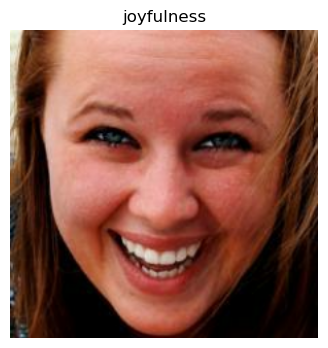

In [55]:
# одно случайное изображение
for images, labels in train_batches.take(30):
    one_pic = images[1].numpy()
    label = labels[1]
    break

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без аугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

## Слои для препроцессинга изображений

### Rescale

Стандартизация значений матриц изображений - обязательная операция, если мы хотим получить хорошие результаты по работе нашей сети. Для использования данной предобученной модели значения матриц изображений необходимо отшкалировать по стандарту от -1 до 1 (именно такой стандарт использовался для обучения этой сети). Есть два способа создания соответствующего слоя:

```python
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input 

или

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
```

In [65]:
rescale = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./127.5, offset=-1,
                                  input_shape=IMAGE_SIZE + (3,),
                                  name='Rescaling')
])

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Минимальное и максимальное значение пикселей: -1.0 0.96862745


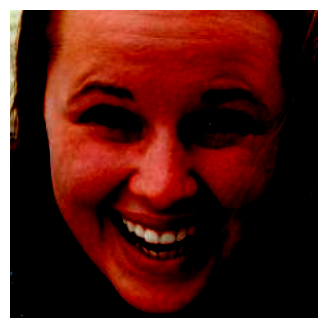

In [57]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result_for_rescale = rescale(np.expand_dims(one_pic, axis=0))
# print(result_for_rescale.shape)

# вернем результату размерность 3 для отображения
result = np.squeeze(result_for_rescale)
# print(result.shape)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Слой отработал ожидаемым образом, при этом видно, что изменился контраст изображения. Это нормально, так как значения матрицы изображений были растянуты по обе стороны от 0. В любом случае, алгоритм обнаруживает зависимости не по внешнему виду картинок, а исходя из численных значений матриц изображений, контраст имеет значение только для нашего, человеческого глаза.

### Аугментация данных

Так как наш датасет создан из сравнительно небольшого набора данных, то для избежания переобучения мы воспользуемся всеми доступными возможностями библиотеки `keras`, в частности, добавим в модель слои агументации, которые искусственным образом увеличат количество изображений через внешнее изменение имеющихся. 

Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast`. 

In [58]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.3), name='RandomZoom'),
    # tf.keras.layers.RandomContrast(factor=(0.1, 0.1), name='RandomContrast')
])

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Минимальное и максимальное значение пикселей: -1.0 0.93738043


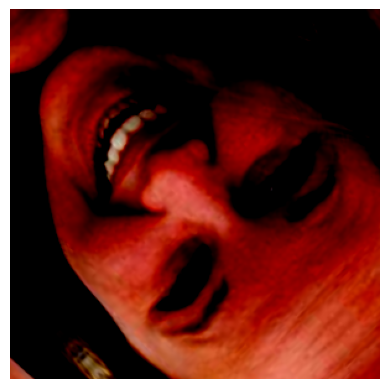

In [59]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug).numpy()
# print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(np.squeeze(augmented));

print("Минимальное и максимальное значение пикселей:", augmented.min(), augmented.max())

Видим, что некоторые каналы из-за усиления контрастности дают выжженные пиксели. Эта особенность будет выправлена следующей операцией - `rescale`, которая при приведении значений к стандарту [-1, 1] также влияет на контраст. В итоге мы получим более менее нормализованную картинку. При желании слой с контрастом, как и другие слои аугментации, всегда можно отключить или изменить параметры, но нас устраивает такой результат.

Итак, обе последовательности вполне успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

## Оптимизация работы кэша

Оптимизируем работу кэша следующим кодом:

In [60]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# <b>Модель 1.1</b> | Pretrained baseline

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем предолеть проблему переобучения, добавив к предыдущей архитектуре слои с аугментацией данных, которые мы подготовили заранее. Другие параметры оставим нетронутыми. Обратим внимание, что мы создаем новую модель, а не дообучаем предыдущую (дообучением мы займемся позже).

In [48]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# feature_extractor.trainable = do_fine_tuning

In [49]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.MobileNet(
#                                                 input_shape=IMG_SHAPE,
#                                                 # alpha=1.0,
#                                                 # depth_multiplier=1,
#                                                 dropout=DROPOUT_RATE,
#                                                 include_top=False,
#                                                 weights="imagenet",
#                                                 # input_tensor=None,
#                                                 # pooling=None,
#                                                 # classes=1000,
#                                                 classifier_activation='softmax',
#                                                 # **kwargs
# )
# feature_extractor.trainable = do_fine_tuning

In [50]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.InceptionV3(
#                                                 include_top=False,
#                                                 weights="imagenet",
#                                                 # input_tensor=None,
#                                                 input_shape=IMG_SHAPE,
#                                                 # pooling=None,
#                                                 # classes=1000,
#                                                 # classifier_activation="softmax",
# )
# feature_extractor.trainable = do_fine_tuning

In [61]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionResNetV2(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [52]:
# feature_extractor.summary()

## Архитектура модели

In [53]:
# image_batch, label_batch = next(iter(train_batches))
# feature_batch = feature_extractor(image_batch)
# print(feature_batch.shape)

(32, 8, 8, 1536)


In [54]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

(32, 1536)


In [55]:
# prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax',
#                                   kernel_regularizer=REGULARIZER
#                                  )
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

(32, 5)


In [73]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

# x = layers.Conv2D(32, (3, 3), padding="same",
#                   strides=strides, activation='relu')(x)
# x = layers.MaxPool2D((2, 2))(x)
# x = layers.Conv2D(32, (3, 3), padding="same",
#                   strides=strides, activation='relu')(x)

x = layers.Flatten()(x)

# x = layers.Dropout(DROPOUT_RATE)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(512, activation="relu")(x)

# x = layers.Dropout(DROPOUT_RATE)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='pretrained_baseline')

model.summary()

Model: "pretrained_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 98304)             0         
                                                                 
 dropout_5 (Dropout)         (None, 98304)             0         
                                               

In [74]:
len(model.trainable_variables)

4

## Компиляция

In [59]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
#               loss='mse',
#               metrics=metrics)

In [75]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

## Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 33s 535ms/step - loss: 5.1003 - accuracy: 0.2657 - PR_AUC: 0.2412 - val_loss: 3.8638 - val_accuracy: 0.4151 - val_PR_AUC: 0.3951 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 11s 339ms/step - loss: 3.2905 - accuracy: 0.3231 - PR_AUC: 0.2931 - val_loss: 2.6574 - val_accuracy: 0.4843 - val_PR_AUC: 0.4783 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 11s 335ms/step - loss: 2.3966 - accuracy: 0.3620 - PR_AUC: 0.3345 - val_loss: 2.0531 - val_accuracy: 0.4906 - val_PR_AUC: 0.4831 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 12s 352ms/step - loss: 1.9597 - accuracy: 0.3759 - PR_AUC: 0.3592 - val_loss: 1.7549 - val_accuracy: 0.5157 - val_PR_AUC: 0.4913 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 11s 328ms/step - loss: 1.7291 - accuracy: 0.3926 - PR_AUC: 0.3823 - val_loss: 1.6062 - val_accuracy: 0.5031 - val_PR_AUC: 0.5021 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [170]:
show_predictions(model, test_batches, visualization=False)

disgust is joyfulness (25.55%)
joyfulness is joyfulness (25.12%)
fear is joyfulness (23.35%)
neutral is joyfulness (26.85%)
neutral is joyfulness (23.33%)
anger is joyfulness (24.26%)
fear is joyfulness (25.26%)
anger is joyfulness (26.73%)
neutral is joyfulness (25.02%)
neutral is joyfulness (26.53%)


### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

In [ ]:
# сохраним данные о модели
model_31 = model
hist_31 = hist
model_31_best_results = model_best_results

## Разморозка слоев

In [92]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [95]:
# с какого слоя мы размораживаем модель
fine_tune_at = 390

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

In [94]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  780
Trainable variables in the feature extractor:  236


### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены. Уменьшим базовый lr, чтобы избежать переобучения нашй уже обученной модели.

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss='mse',
#               metrics=metrics)

In [81]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR/100),
              loss='categorical_crossentropy',
              metrics=metrics)

### Архитектура модели

In [82]:
model.summary()

Model: "pretrained_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 98304)             0         
                                                                 
 dropout_5 (Dropout)         (None, 98304)             0         
                                               

In [83]:
len(model.trainable_variables)

115

### Обучение

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, visualization=False)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

In [ ]:
# сохраним данные о модели
model_31_unfreeze = model
hist_31_unfreeze = hist
model__31_unfreeze_best_results = model_best_results

# <b>Модель 3.2</b> | Pretrained ConvNet

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем предолеть проблему переобучения, добавив к предыдущей архитектуре слои с аугментацией данных, которые мы подготовили заранее. Другие параметры оставим нетронутыми. Обратим внимание, что мы создаем новую модель, а не дообучаем предыдущую (дообучением мы займемся позже).

In [48]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# feature_extractor.trainable = do_fine_tuning

In [49]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.MobileNet(
#                                                 input_shape=IMG_SHAPE,
#                                                 # alpha=1.0,
#                                                 # depth_multiplier=1,
#                                                 dropout=DROPOUT_RATE,
#                                                 include_top=False,
#                                                 weights="imagenet",
#                                                 # input_tensor=None,
#                                                 # pooling=None,
#                                                 # classes=1000,
#                                                 classifier_activation='softmax',
#                                                 # **kwargs
# )
# feature_extractor.trainable = do_fine_tuning

In [50]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.InceptionV3(
#                                                 include_top=False,
#                                                 weights="imagenet",
#                                                 # input_tensor=None,
#                                                 input_shape=IMG_SHAPE,
#                                                 # pooling=None,
#                                                 # classes=1000,
#                                                 # classifier_activation="softmax",
# )
# feature_extractor.trainable = do_fine_tuning

In [84]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionResNetV2(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [52]:
# feature_extractor.summary()

## Архитектура модели

In [85]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Conv2D(32, (3, 3), padding="same",
                  strides=strides, activation='relu')(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), padding="same",
                  strides=strides, activation='relu')(x)

x = layers.Flatten()(x)

# x = layers.Dropout(DROPOUT_RATE)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(512, activation="relu")(x)

# x = layers.Dropout(DROPOUT_RATE)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='pretrained_convnet')

model.summary()

Model: "pretrained_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_413 (Conv2D)         (None, 4, 4, 32)          442400    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                          

In [86]:
len(model.trainable_variables)

8

## Компиляция

In [59]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
#               loss='mse',
#               metrics=metrics)

In [75]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

## Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 33s 535ms/step - loss: 5.1003 - accuracy: 0.2657 - PR_AUC: 0.2412 - val_loss: 3.8638 - val_accuracy: 0.4151 - val_PR_AUC: 0.3951 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 11s 339ms/step - loss: 3.2905 - accuracy: 0.3231 - PR_AUC: 0.2931 - val_loss: 2.6574 - val_accuracy: 0.4843 - val_PR_AUC: 0.4783 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 11s 335ms/step - loss: 2.3966 - accuracy: 0.3620 - PR_AUC: 0.3345 - val_loss: 2.0531 - val_accuracy: 0.4906 - val_PR_AUC: 0.4831 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 12s 352ms/step - loss: 1.9597 - accuracy: 0.3759 - PR_AUC: 0.3592 - val_loss: 1.7549 - val_accuracy: 0.5157 - val_PR_AUC: 0.4913 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 11s 328ms/step - loss: 1.7291 - accuracy: 0.3926 - PR_AUC: 0.3823 - val_loss: 1.6062 - val_accuracy: 0.5031 - val_PR_AUC: 0.5021 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, visualization=False)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

In [ ]:
# сохраним данные о модели
model_32 = model
hist_32 = hist
model_32_best_results = model_best_results

## Разморозка слоев

In [87]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [88]:
# с какого слоя мы размораживаем модель
fine_tune_at = 390

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

In [89]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  780
Trainable variables in the feature extractor:  111


### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss='mse',
#               metrics=metrics)

In [81]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR/100),
              loss='categorical_crossentropy',
              metrics=metrics)

### Архитектура модели

In [82]:
model.summary()

Model: "pretrained_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 98304)             0         
                                                                 
 dropout_5 (Dropout)         (None, 98304)             0         
                                               

In [83]:
len(model.trainable_variables)

115

### Обучение

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, visualization=False)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

In [ ]:
# сохраним данные о модели
model_32_unfreeze = model
hist_32_unfreeze = hist
model__32_unfreeze_best_results = model_best_results

# <b>Модель 3.3</b> | Pretrained Deeper ConvNet

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем предолеть проблему переобучения, добавив к предыдущей архитектуре слои с аугментацией данных, которые мы подготовили заранее. Другие параметры оставим нетронутыми. Обратим внимание, что мы создаем новую модель, а не дообучаем предыдущую (дообучением мы займемся позже).

In [48]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# feature_extractor.trainable = do_fine_tuning

In [49]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.MobileNet(
#                                                 input_shape=IMG_SHAPE,
#                                                 # alpha=1.0,
#                                                 # depth_multiplier=1,
#                                                 dropout=DROPOUT_RATE,
#                                                 include_top=False,
#                                                 weights="imagenet",
#                                                 # input_tensor=None,
#                                                 # pooling=None,
#                                                 # classes=1000,
#                                                 classifier_activation='softmax',
#                                                 # **kwargs
# )
# feature_extractor.trainable = do_fine_tuning

In [50]:
# do_fine_tuning = False
# feature_extractor = tf.keras.applications.InceptionV3(
#                                                 include_top=False,
#                                                 weights="imagenet",
#                                                 # input_tensor=None,
#                                                 input_shape=IMG_SHAPE,
#                                                 # pooling=None,
#                                                 # classes=1000,
#                                                 # classifier_activation="softmax",
# )
# feature_extractor.trainable = do_fine_tuning

In [96]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionResNetV2(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [52]:
# feature_extractor.summary()

## Архитектура модели

In [97]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Conv2D(32, (3, 3), padding="same",
                  strides=strides, activation='relu')(x)
x = layers.MaxPool2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), padding="same",
                  strides=strides, activation='relu')(x)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation="relu")(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation="relu")(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='pretrained_deeper')

model.summary()

Model: "pretrained_deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_618 (Conv2D)         (None, 4, 4, 32)          442400    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                            

In [98]:
len(model.trainable_variables)

20

## Компиляция

In [59]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
#               loss='mse',
#               metrics=metrics)

In [99]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR/100),
              loss='categorical_crossentropy',
              metrics=metrics)

## Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 33s 535ms/step - loss: 5.1003 - accuracy: 0.2657 - PR_AUC: 0.2412 - val_loss: 3.8638 - val_accuracy: 0.4151 - val_PR_AUC: 0.3951 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 11s 339ms/step - loss: 3.2905 - accuracy: 0.3231 - PR_AUC: 0.2931 - val_loss: 2.6574 - val_accuracy: 0.4843 - val_PR_AUC: 0.4783 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 11s 335ms/step - loss: 2.3966 - accuracy: 0.3620 - PR_AUC: 0.3345 - val_loss: 2.0531 - val_accuracy: 0.4906 - val_PR_AUC: 0.4831 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 12s 352ms/step - loss: 1.9597 - accuracy: 0.3759 - PR_AUC: 0.3592 - val_loss: 1.7549 - val_accuracy: 0.5157 - val_PR_AUC: 0.4913 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 11s 328ms/step - loss: 1.7291 - accuracy: 0.3926 - PR_AUC: 0.3823 - val_loss: 1.6062 - val_accuracy: 0.5031 - val_PR_AUC: 0.5021 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, visualization=False)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

In [ ]:
# сохраним данные о модели
model_33 = model
hist_33 = hist
model_33_best_results = model_best_results

## Разморозка слоев

In [100]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [101]:
# с какого слоя мы размораживаем модель
fine_tune_at = 390

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

In [102]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  780
Trainable variables in the feature extractor:  243


### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss='mse',
#               metrics=metrics)

In [103]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Архитектура модели

In [104]:
model.summary()

Model: "pretrained_deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_618 (Conv2D)         (None, 4, 4, 32)          442400    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                            

In [105]:
len(model.trainable_variables)

263

### Обучение

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model, visualization=False)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

In [ ]:
# сохраним данные о модели
model_33_unfreeze = model
hist_33_unfreeze = hist
model__33_unfreeze_best_results = model_best_results

# <b>Использованные источники и литература</b>

**Курсы**

1. Holbrook R. Intro to Deep Learning // https://www.kaggle.com/learn/intro-to-deep-learning
1. Moroney L. Device-based Models with TensorFlow Lite // https://www.coursera.org/learn/device-based-models-tensorflow

**Статьи**
1. Confusion Matrix // https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html 
1. Load and preprocess images // https://www.tensorflow.org/tutorials/load_data/images
1. Module: tf.data.Dataset // https://www.tensorflow.org/api_docs/python/tf/data/Dataset
1. Module: tf.keras.applications.mobilenet_v2 // https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v
1. Transfer learning and fine-tuning // https://www.tensorflow.org/tutorials/images/transfer_learning
1. Transfer learning and fine-tuning // https://keras.io/guides/transfer_learning/
1. Lakhani N.D. Statistical Evaluation Metrics // https://iust-projects.ir/post/minidm01/

**Форумы**
1. StackOverflow // https://stackoverflow.com/
1. GitHub // https://github.com/